# SpaGE Tutorial

## Prediction of spatial patterns for unmeasured genes using scRNA-seq data

Step-by-step vignette showing the integration of the **osmFISH** spatial data with the **AllenSSp** scRNA-seq data, and the prediction of new spatial gene patterns using *SpaGE*

#### Import useful libraries

In [1]:
import numpy as np
import pandas as pd
import loompy
import matplotlib.pyplot as plt
import scipy.stats as st
from SpaGE.main import SpaGE
import warnings
warnings.filterwarnings('ignore')

#### Load and preprocess the AllenSSp dataset

In [2]:
RNA_data = pd.read_csv('SSp_exons_matrix.csv',header=0,index_col=0,sep=',')

# filter lowely expressed genes
Genes_count = np.sum(RNA_data > 0, axis=1)
RNA_data = RNA_data.loc[Genes_count >=10,:]
del Genes_count

# Normalization
def Log_Norm_cpm(x):
    return np.log(((x/np.sum(x))*1000000) + 1)
RNA_data = RNA_data.apply(Log_Norm_cpm,axis=0)

#### Load and preprocess the osmFISH dataset

In [3]:
ds = loompy.connect('osmFISH_SScortex_mouse_all_cells.loom')
FISH_Genes = ds.ra['Gene']   
colAtr = ds.ca.keys()

df = pd.DataFrame()
for i in colAtr:
    df[i] = ds.ca[i]

osmFISH_meta = df.iloc[np.where(df.Valid == 1)[0], :]
osmFISH_data = ds[:,:]
osmFISH_data = osmFISH_data[:,np.where(df.Valid == 1)[0]]
osmFISH_data = pd.DataFrame(data= osmFISH_data, index= FISH_Genes)

del ds, colAtr, i, df, FISH_Genes

# Select cortical regions only to match the AllenSSp dataset
Cortex_Regions = ['Layer 2-3 lateral', 'Layer 2-3 medial', 'Layer 3-4', 
                  'Layer 4','Layer 5', 'Layer 6', 'Pia Layer 1']
Cortical = np.stack(i in Cortex_Regions for i in osmFISH_meta.Region)

osmFISH_meta = osmFISH_meta.iloc[Cortical,:]
osmFISH_data = osmFISH_data.iloc[:,Cortical]
del Cortex_Regions,Cortical

# Normalization
cell_count = np.sum(osmFISH_data,axis=0)
def Log_Norm_spatial(x):
    return np.log(((x/np.sum(x))*np.median(cell_count)) + 1)
osmFISH_data = osmFISH_data.apply(Log_Norm_spatial,axis=0)

#### Validate SpaGE using Leave-one-gene-out cross validation

Use SpaGE to predict the expression of one left-out gene and compare prediction with the measured expression. For visualization purpose, we only show five genes with known spatial patterns. However, the full set of shared genes between the two datasets can be tested.

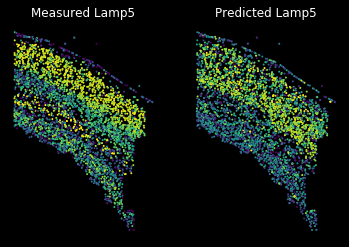

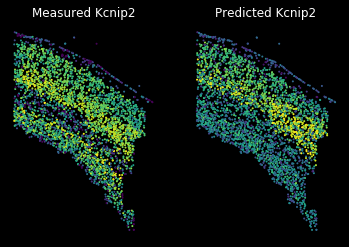

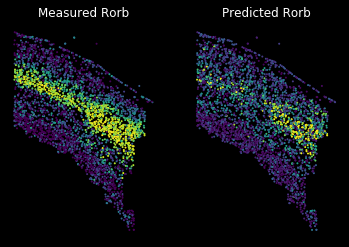

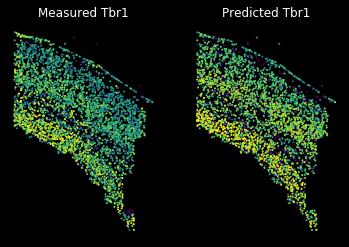

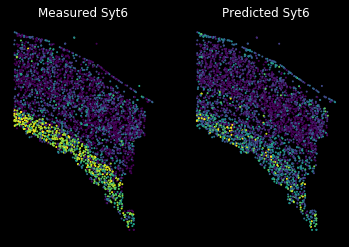

In [4]:
### Leave-one-gene-out cross validation for Lamp5, Kcnip2, Rorb, Tbr1 and Syt6
Gene_set = ['Lamp5','Kcnip2','Rorb','Tbr1','Syt6']
Correlations = pd.Series(index = Gene_set)
plt.style.use('dark_background')

for i in Gene_set:
    Imp_Genes = SpaGE(osmFISH_data.T.drop(i,axis=1),RNA_data.T,n_pv=30,
                           genes_to_predict = [i])
    Correlations[i] = st.spearmanr(osmFISH_data.T[i],Imp_Genes[i])[0]
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.axis('off')
    cmap = osmFISH_data.T[i]
    cmap[cmap > np.percentile(cmap,99)] = np.percentile(cmap,99)
    ax1.scatter(osmFISH_meta['X'],osmFISH_meta['Y'],s=1,c=cmap)
    ax1.set_title('Measured ' + i, fontsize = 12)
    ax1.set_ylabel(i)
    
    ax2.axis('off')
    cmap = Imp_Genes[i]
    cmap[cmap > np.percentile(cmap,99)] = np.percentile(cmap,99)
    ax2.scatter(osmFISH_meta['X'],osmFISH_meta['Y'],s=1,c=cmap)
    ax2.set_title('Predicted ' + i, fontsize = 12)

#### Correlation values between measured and predicted expressions

In [5]:
print(Correlations)

Lamp5     0.412915
Kcnip2    0.419512
Rorb      0.497496
Tbr1      0.543648
Syt6      0.379520
dtype: float64


#### Prediction of new unmeasured spatial gene patterns

Here we show the predicted spatial pattern for 10 new genes, not measured in the **osmFISH** data. These genes have clear spatial patterns, related to specific layers in the mouse cortex. These patterns are in agreement with the Allen ISH data http://mouse.brain-map.org/.

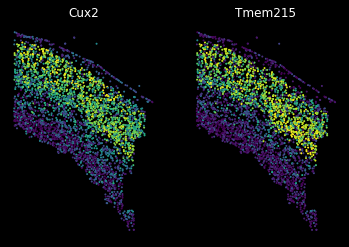

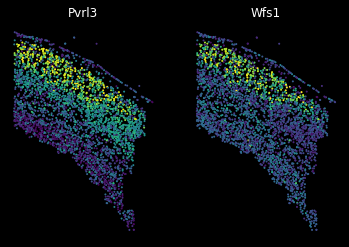

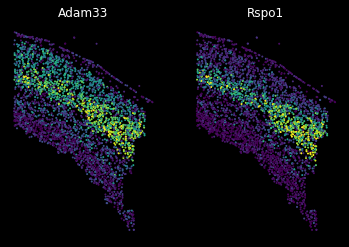

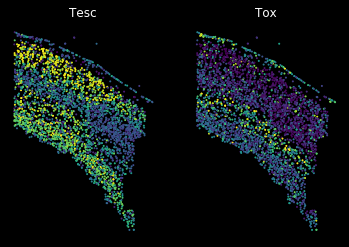

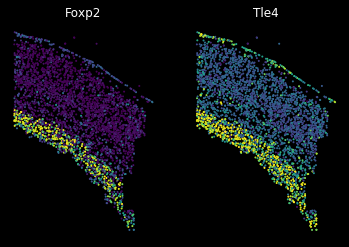

In [6]:
new_genes = ['Cux2','Tmem215','Pvrl3','Wfs1','Adam33','Rspo1','Tesc','Tox','Foxp2','Tle4']
Imp_New_Genes = SpaGE(osmFISH_data.T,RNA_data.T,n_pv=30,
                           genes_to_predict = new_genes)

for i in [0,2,4,6,8]:
    fig,(ax1, ax2) = plt.subplots(1,2)
    ax1.axis('off')
    cmap = Imp_New_Genes[new_genes[i]]
    cmap[cmap > np.percentile(cmap,99)] = np.percentile(cmap,99)
    ax1.scatter(osmFISH_meta['X'],osmFISH_meta['Y'],s=1,c=cmap)
    ax1.set_title(new_genes[i], fontsize = 12)
    
    ax2.axis('off')
    cmap = Imp_New_Genes[new_genes[i+1]]
    cmap[cmap > np.percentile(cmap,99)] = np.percentile(cmap,99)
    ax2.scatter(osmFISH_meta['X'],osmFISH_meta['Y'],s=1,c=cmap)
    ax2.set_title(new_genes[i+1], fontsize = 12)